### Predicting Aircraft Remaining Useful Life (RUL) Using Machine Learning

To develop a machine learning framework capable of accurately predicting the remaining useful life of aircraft components based on their historical performance data. This will enable proactive maintenance strategies to ensure optimal aircraft reliability and performance.

#### Methodology:
##### Data Acquisition: 
Utilize the NASA C-MAPSS dataset, which contains comprehensive information on aircraft engine performance throughout their lifecycles.
##### original resource : 
https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data
##### Data Set: FD001 will use as training dataset
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

##### Feature Engineering:
Extract relevant features from the raw data, such as sensor readings, operating conditions, and maintenance history.
##### Model Selection and Training:
Experiment with various regression and classification models (e.g., Linear Regression, Decision Tree, Random Forest, SVM , XGBoost) to identify the most effective approach for predicting RUL.

##### Model Evaluation: 
Assess the performance of each model using appropriate metrics (e.g., accuracy, Mean Absolute Error) to select the best-performing model.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use('bmh')

In [2]:
column_names = ['engine', 'time', 'op_setting_1', 'op_setting_2', 
                'op_setting_3'] + [f'sm_{i}' for i in range(1, 22)]
#df_train.columns = column_names
#df_test.columns = column_names

In [3]:
# assign names to columns , save in dict_list 
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

i=1
for x in dict_list :
    Sensor_dictionary[f'sm_{i}']=x
    i+=1
Sensor_dictionary

{'sm_1': '(Fan inlet temperature) (◦R)',
 'sm_2': '(LPC outlet temperature) (◦R)',
 'sm_3': '(HPC outlet temperature) (◦R)',
 'sm_4': '(LPT outlet temperature) (◦R)',
 'sm_5': '(Fan inlet Pressure) (psia)',
 'sm_6': '(bypass-duct pressure) (psia)',
 'sm_7': '(HPC outlet pressure) (psia)',
 'sm_8': '(Physical fan speed) (rpm)',
 'sm_9': '(Physical core speed) (rpm)',
 'sm_10': '(Engine pressure ratio(P50/P2)',
 'sm_11': '(HPC outlet Static pressure) (psia)',
 'sm_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 'sm_13': '(Corrected fan speed) (rpm)',
 'sm_14': '(Corrected core speed) (rpm)',
 'sm_15': '(Bypass Ratio) ',
 'sm_16': '(Burner fuel-air ratio)',
 'sm_17': '(Bleed Enthalpy)',
 'sm_18': '(Required fan speed)',
 'sm_19': '(Required fan conversion speed)',
 'sm_20': '(High-pressure turbines Cool air flow)',
 'sm_21': '(Low-pressure turbines Cool air flow)'}

## load data

In [4]:
# this is RUL of each engine on test set. 100 row 
data_val = pd.read_csv(os.path.join("data", "test_FD001.txt"),sep=' ',header=None,index_col=False,names=column_names)
data_train = pd.read_csv(os.path.join("data", "train_FD001.txt"),sep=' ',header=None,index_col=False,names=column_names)
y_val = pd.read_csv(os.path.join("data", "RUL_FD001.txt"),sep=' ',header=None,index_col=False,names=['RUL'])
data_val.shape , y_val.shape, data_train.shape

C:\Users\alexa\AppData\Local\Temp\ipykernel_11712\3083354820.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data_val = pd.read_csv(os.path.join("data", "test_FD001.txt"),sep=' ',header=None,index_col=False,names=column_names)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11712\3083354820.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data_train = pd.read_csv(os.path.join("data", "train_FD001.txt"),sep=' ',header=None,index_col=False,names=column_names)


((13096, 26), (100, 1), (20631, 26))

#### THERE IS 2 MAIN APPROACH FOR THIS PROBELM   

#### 2.dynamic model
dynamic RLU prediction , predict RUL at each time step , looking for degradation pattern , capture long term dependency , anomoly detection , continious monitoring , 
CONSIDER WHOLE DATAFRAME(HISTORICAL DATA) AND TREATE AS TIME SERIES PROBLEM AND SOLEVE WITH RNN , LSTM , GRU.

## data cleaning

In [5]:
# usefull info of dataset
df_info = pd.concat ( [data_train.isna().sum() , data_train.nunique() , data_train.dtypes] , axis = 1  )
df_info.columns = ['missing value' , 'number unique value' , 'dtype']
df_info
# no missing value , no categorical value , thanks!

,missing value,number unique value,dtype
engine,0,100,int64
time,0,362,int64
op_setting_1,0,158,float64
op_setting_2,0,13,float64
op_setting_3,0,1,float64
sm_1,0,1,float64
sm_2,0,310,float64
sm_3,0,3012,float64
sm_4,0,4051,float64
sm_5,0,1,float64


## data preprocessing

In [6]:
# make copy of original dataset , assing new name for dataframes
df = data_train.copy()
df_val = data_val.copy()
print(df.shape , df_val.shape)

(20631, 26) (13096, 26)


### detect and drop constant features

In [7]:
def constant_feature(df):
    constant_feature = []
    for col in df.columns:
            if abs(df[col].std() < 0.02):      # hint
                constant_feature.append(col)
    
    return constant_feature

#### hint
we can use 
    
    df[col].min() == df[col].max()

Drop features with a standard deviation less than 0.02. This identifies features with minimal variation, indicating they are likely constant or nearly constant. While using `df[col].min() == df[col].max()` can also detect constant features, it might miss features with a few slightly different values. The standard deviation provides a more robust measure of variability.
for example , sm_6 has 21.6 for 400 sample , and for rest sample(26000-400) is 21.61.
so min = max , will not consider constant , but it can consider constant,variation is veryyy small

In [8]:
df = data_train.copy()
df_val = data_val.copy()
print( constant_feature(df) )

df.drop(columns=constant_feature(df)  , inplace = True)
df_val.drop(columns=constant_feature(df) , inplace = True)

df.columns

['op_setting_1', 'op_setting_2', 'op_setting_3', 'sm_1', 'sm_5', 'sm_6', 'sm_10', 'sm_16', 'sm_18', 'sm_19']


Index(['engine', 'time', 'sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_9',
       'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21'],
      dtype='object')

### create rul feature

In [9]:
# defining RUL for training dataset
# RUL is rest useful life for each engines instant 
# for engine 1 , max time will be true RUL , we can subtract every time from max time 
# it gives us rul for each engins' states
# it is grouped data by engine , and for every engine , take time's columns , and take max value of time
# assign max times of each engine for all of engine's , then subtract it by its time , result is rul
def create_rul(df):
    df['rul'] = df.groupby('engine')['time'].transform('max') - df['time']
    return df
create_rul(df)

,engine,time,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21,rul
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


### detect high corrolated features

In [10]:
mask = np.triu(np.ones(df.shape).astype(bool))
# np.ones( shape of matrix)    return matrix with 1 , shape is specified
# np.triu( matrix , k = 1 )    return upper triangle of matrix , k = 1 exclude diagnoal , k = 0 diagnoal included        
# mask is a matrix with 0 value for all shape expect upper triangle

In [11]:
df_corr = df.corr()
mask = np.tril(np.ones(df_corr.shape),k = -1).astype(bool)
df_corr = df_corr.where(mask)
df_corr

,engine,time,sm_2,sm_3,sm_4,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21,rul
engine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,0.078753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_2,0.014133,0.549898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_3,0.012621,0.543947,0.602610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_4,0.026116,0.624577,0.714949,0.678413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_7,-0.032073,-0.595914,-0.702136,-0.664595,-0.793130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_8,0.039929,0.475977,0.662325,0.602481,0.746852,-0.767132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_9,-0.052053,0.443999,0.273764,0.322964,0.297429,-0.217835,-0.032091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_11,0.024707,0.634385,0.740020,0.695900,0.830136,-0.822805,0.782213,0.274591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_12,-0.031882,-0.611354,-0.724578,-0.680307,-0.815591,0.812713,-0.786540,-0.210238,-0.846884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'correlation'}>

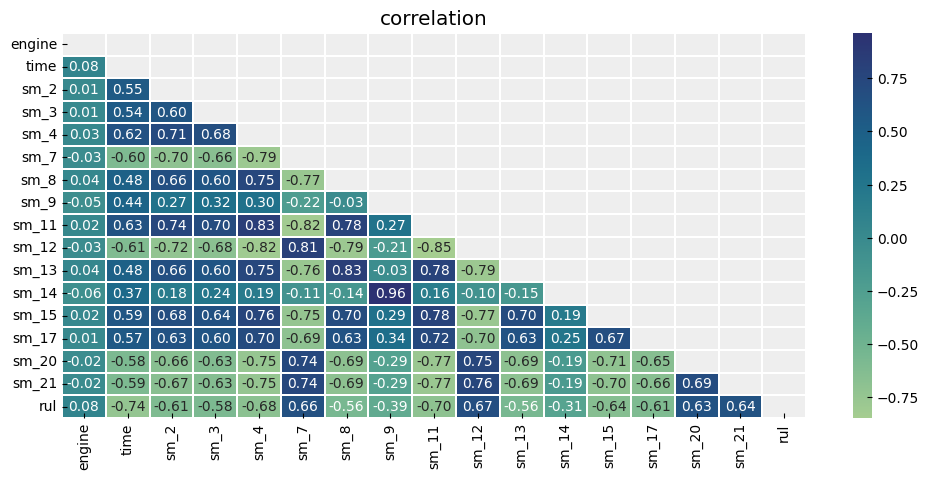

In [12]:
plt.figure(figsize = (12,5))
plt.grid() , plt.title('correlation')
sns.heatmap(df_corr , annot=True , fmt = '0.2f' , cmap='crest' , linewidths=0.01)

rul has good correlation with sensor measurements.
engine is ID , so it is irrelevant

<Axes: >

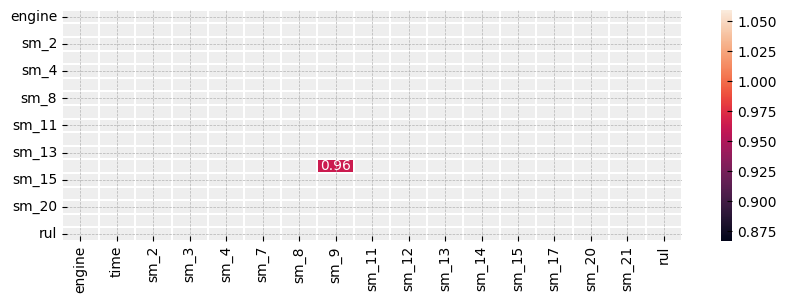

In [13]:
# visualization high corrolated features 
plt.figure(figsize = (10,3))
mask = df_corr.where( abs(df_corr) > 0.95 ).isna()
sns.heatmap(df_corr , annot=True , fmt = '0.2f' , linewidths=0.1 , mask = mask )

In [14]:
# detect more than 95% correlation
high_corr = []
for col in df_corr.columns:
    for row in df_corr.index:
        if abs(df_corr.loc[col , row]) > 0.95 :
            high_corr.append((col , row))
high_corr

[('sm_14', 'sm_9')]

In [15]:
# these 2 feature has very high correlation , no need for both of them , we can drop one of them
df.drop(columns = ['sm_9'] , inplace = True)

In [16]:
df.columns

Index(['engine', 'time', 'sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_11',
       'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21', 'rul'],
      dtype='object')

## EDA

In [17]:
data_train['time'].describe().T
# there is 100 units(engins)
# time in cycles is between 1 time - 362 in cycle , cycle could be every turbin run

count    20631.000000
mean       108.807862
std         68.880990
min          1.000000
25%         52.000000
50%        104.000000
75%        156.000000
max        362.000000
Name: time, dtype: float64

In [18]:
# max , or failure time for each engine , or max time cycle , that engine has worked.
failure_time = df.groupby('engine')['rul'].max()

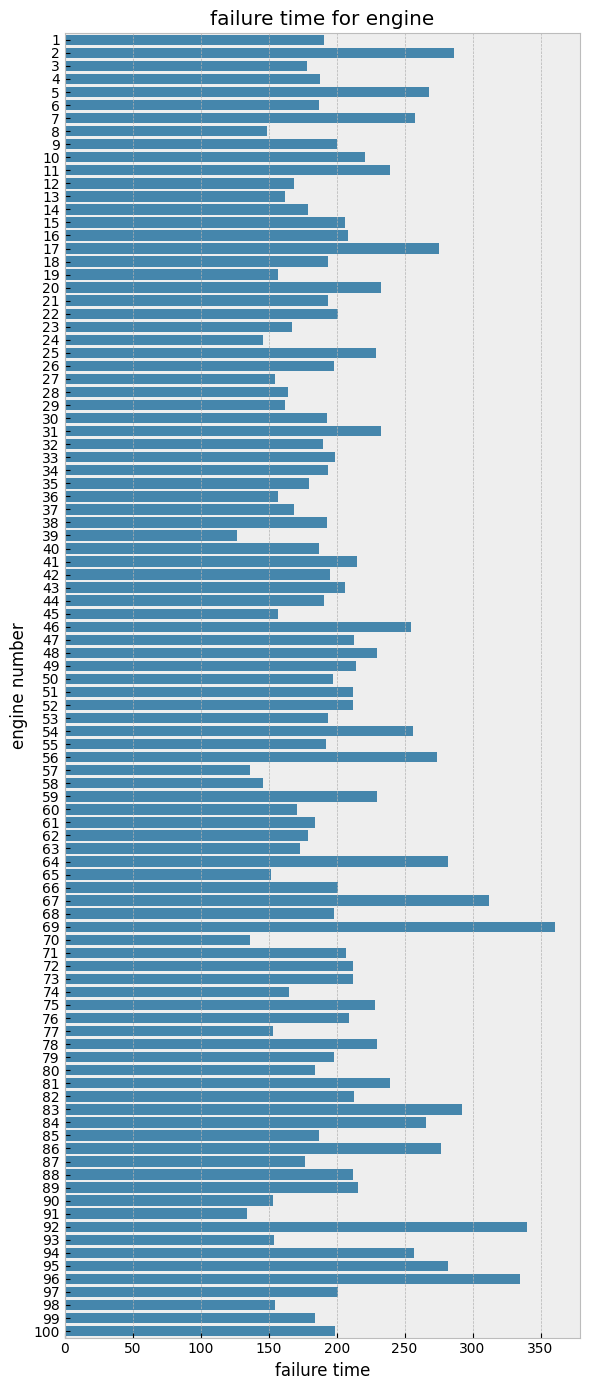

In [19]:
plt.figure(figsize = (6,14))
sns.barplot(y = failure_time.index , x = failure_time.values , orient='h')
plt.title('failure time for engine')
plt.xlabel('failure time')
plt.ylabel('engine number')
plt.tight_layout()
plt.show()

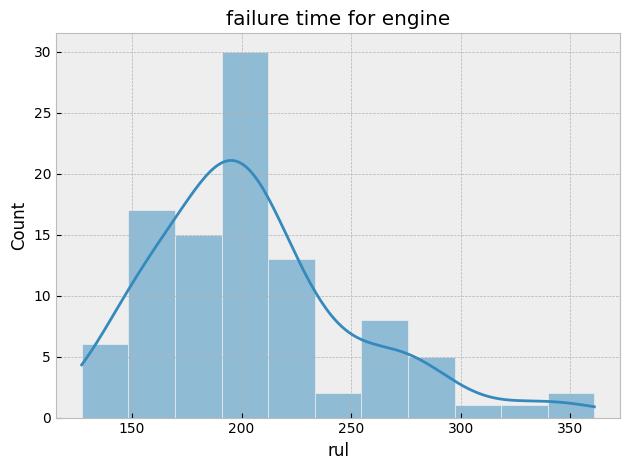

In [20]:
# distribution of failure time per engine
sns.histplot(failure_time , kde=True)
plt.title('failure time for engine')
plt.tight_layout()

# sensor visualization

In [21]:
def plot_signal(df , signal_name , Sensor_dictionary):
    figure = plt.figure(figsize=(10,4))

    for engine in df['engine'].unique():  # hint
        if (engine % 10 ==0 ):
            #print(engine)
            rolling_window = df[ df['engine']==engine ].rolling(10).mean()
            sns.lineplot( data = rolling_window , x = 'rul' , y =signal_name  , label =engine)
    
    plt.tight_layout(), plt.xlim(250 , 0)
    plt.xlabel('Remainded Usefull Life (RUL)') , plt.ylabel(Sensor_dictionary[signal_name])
    plt.show()

#### hint
    df['engine'] == 10    engine number 10
for engine number 10 , it calculate , moving average of 10 frame MA(10)<br>
current value + 9 previous value  , this is for smoothing<br>
rolling(100).mean  make very smooth<br>
rollung(0).mean   it is same as , ploting each point of 222 row of engine 10 <br>
    
    for engine in df['engine'].unique():
            if (engine % 10 ==0 ):
                #print(engine)
                rolling_window = df[ df['engine']==engine ].rolling(10).mean()
                print(f'engine number {engine}')
                print(rolling_window)
                print('-' * 20)

<Figure size 1000x400 with 0 Axes>

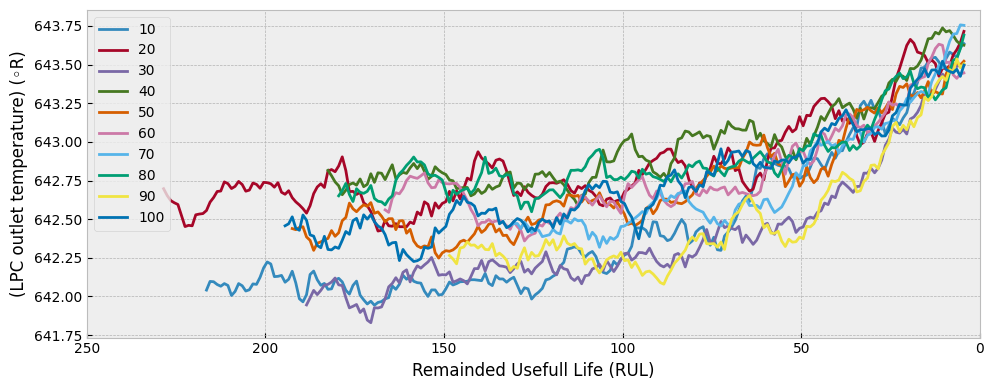

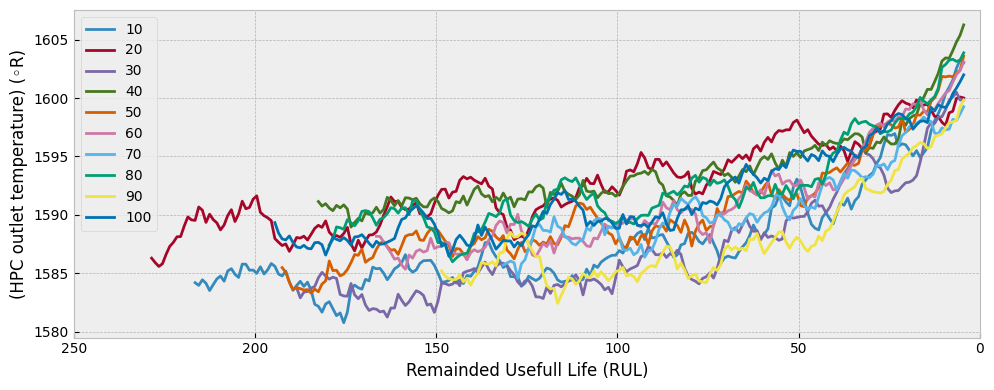

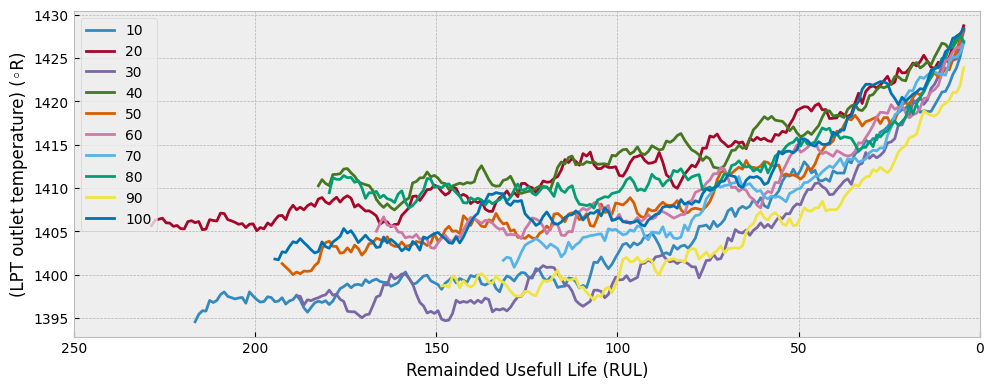

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

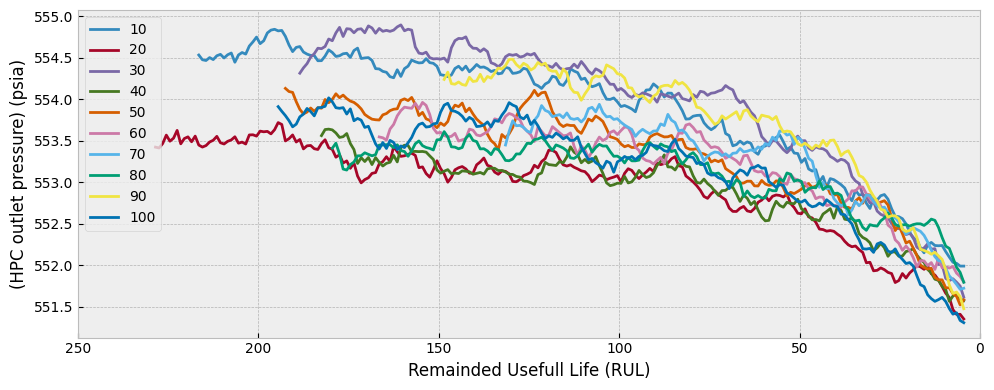

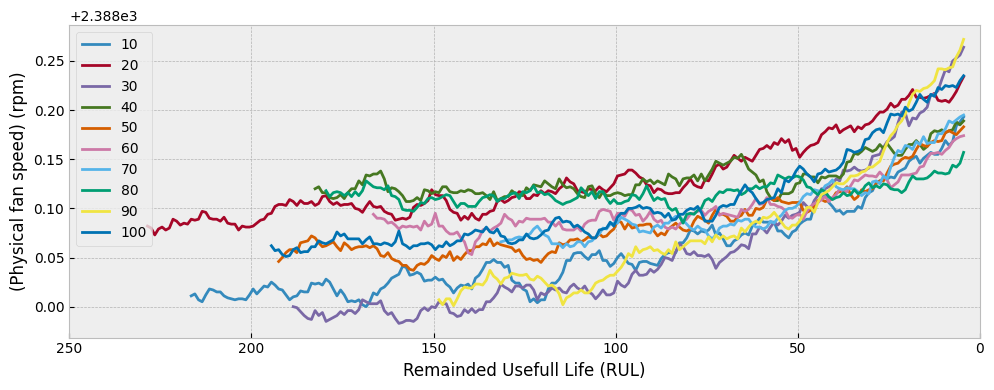

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

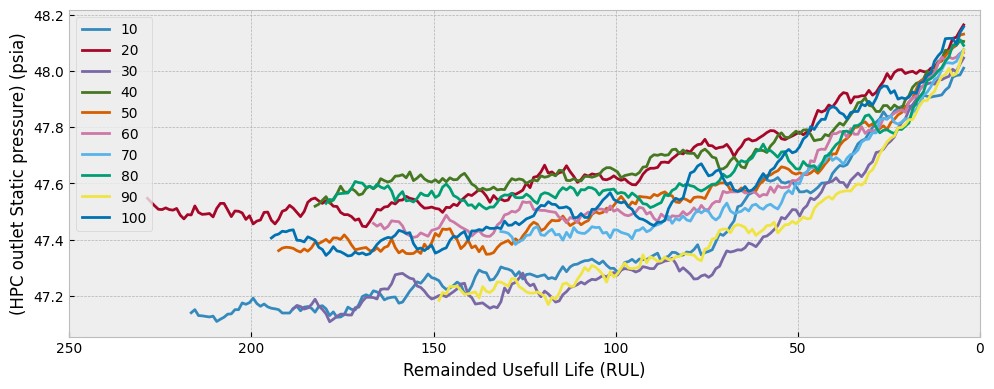

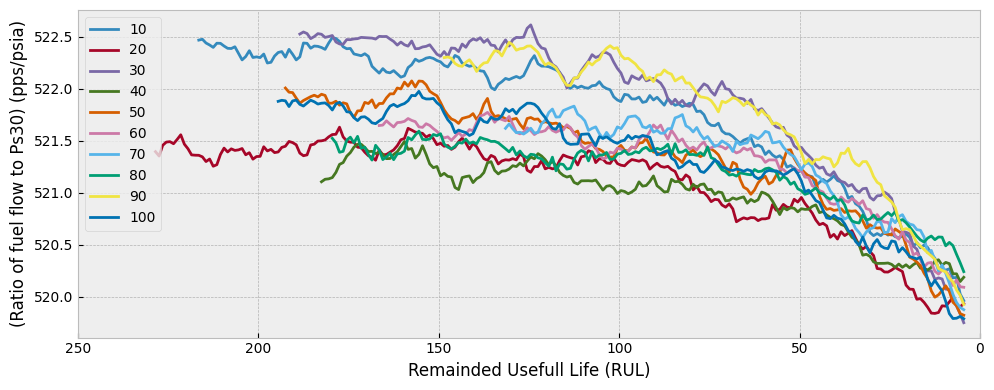

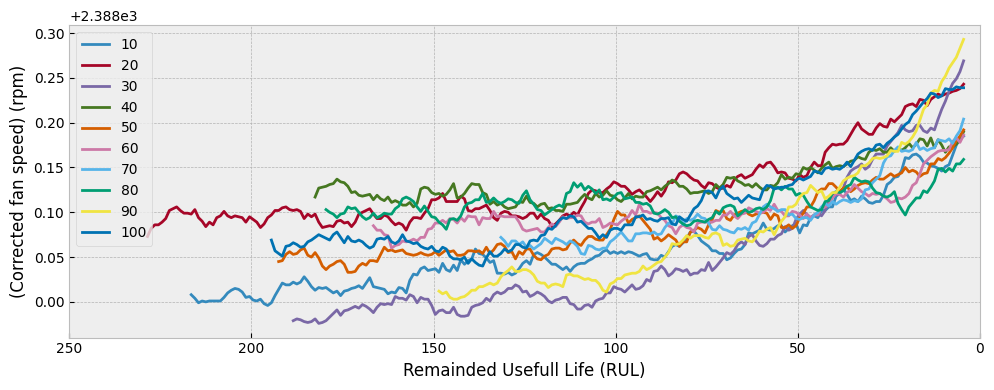

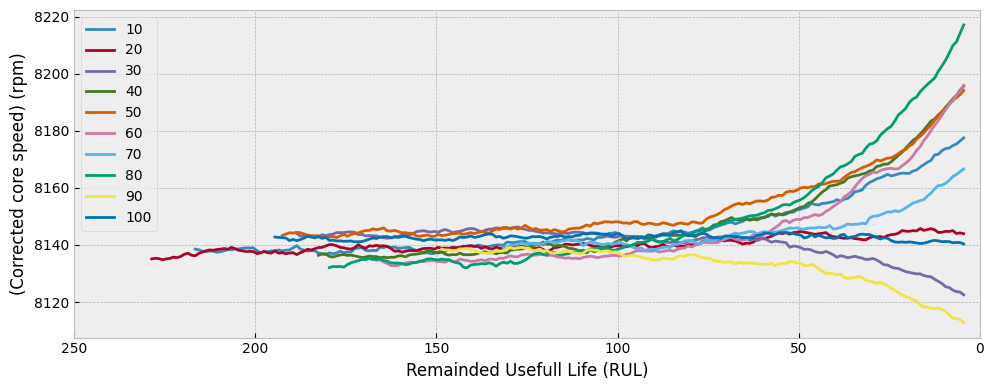

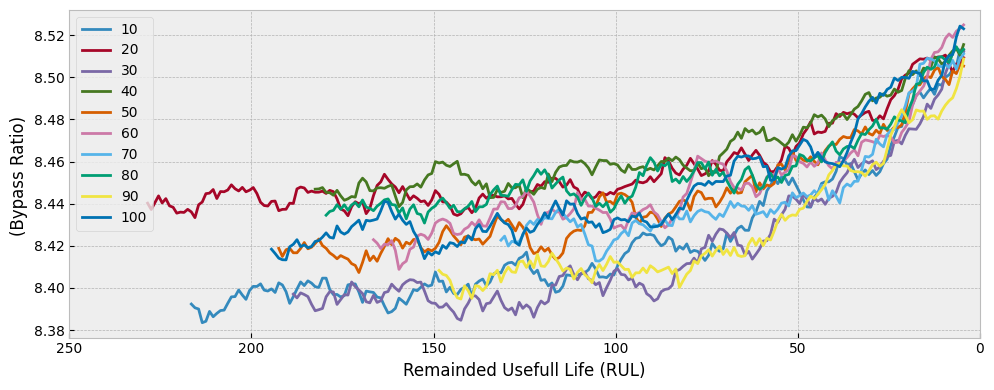

<Figure size 1000x400 with 0 Axes>

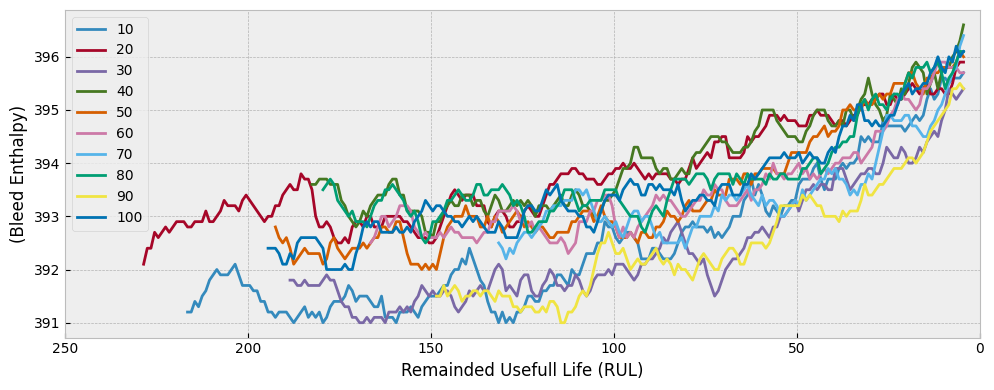

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

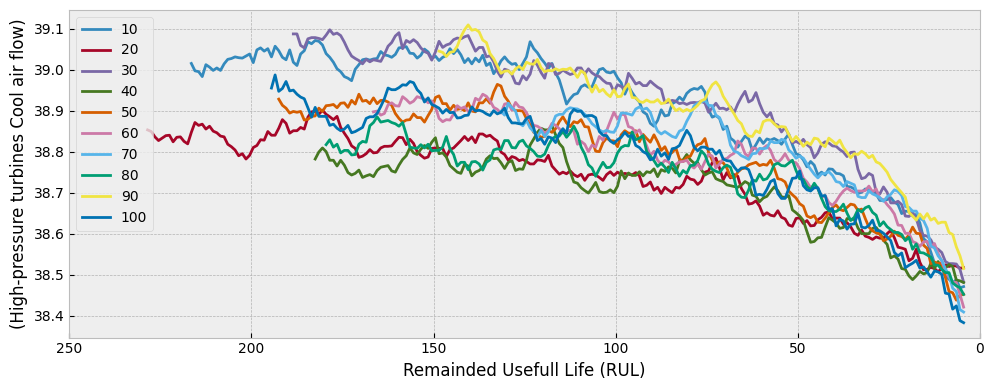

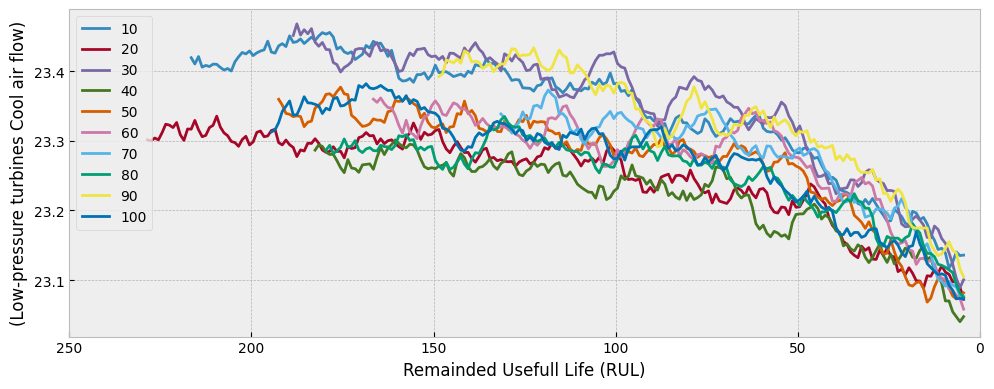

In [22]:
for i in range (1,22):
    try:
        plot_signal(df , 'sm_'+str(i)  , Sensor_dictionary)
    except:
        pass

# what are we doing
max time cycle , and RUL , they are opposite 
RUL in time cycle  = 1  , means rest of useful life , at beginings , and it belongs in dataframe to time of 1 
and max time in cycle for engin is eaquall RUL of 0 .means failed in this point.

in this case our target (label , y) could be df['rul'] , or df['time']
but we stick to one of them.
in **predictive maintenance** it is common consider RUL as target.

nasa has 3 sheet for dataset :  
1.train with 26000 sample , named  df , which , after preprocessing and EDA , and feature selection 

2.test set with 13000 sample , name it df_val ( for misleading i choose validation name instead of test)

3.rul for test set (df_val) , name it y_val , and its shape is 100x1 ( target or label or RUL for every engine in validation set of nasa)
so , df_train , df_val , y_val 

Split df_train  to train and test set
X_train , X_test , y_train , y_test  = train_test_split(X, y, test_size=0.2 , random_state=42)


for validation set , we take last registerd time for each engine , rul value for validation set (y_val) is rest useful time after max time of validation set , so take last reading of each engine , and convert validation set to 100 sample data , so X for validation set :
    
    X_val = df_val.groupby('engine').last().reset_index()
now , x_val is 100 sample of max time registerd in val set.  

### feture selection

In [23]:
print(df.columns)
features = df.columns[2:-1]   # drop  engine , time , rul of  dataset
features                      # for X ( train and val)

Index(['engine', 'time', 'sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_11',
       'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21', 'rul'],
      dtype='object')


Index(['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_11', 'sm_12', 'sm_13',
       'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21'],
      dtype='object')

we split train dataset to train and test , validation set( nasa separate dataset fot evaluating)

In [24]:
# train set
from sklearn.model_selection import train_test_split
X = df[features]
y = df['rul']

X_train , X_test , y_train , y_test  = train_test_split(X, y, test_size=0.2 , random_state=42)

In [25]:
# validation set 
X_val = df_val.groupby('engine').last().reset_index()    # take last row per engine , shows max time
X_val = X_val[features]   # no need for time in val set too

In [26]:
X_train.shape , X_test.shape , X_val.shape

((16504, 13), (4127, 13), (100, 13))

### Transforming data

In [27]:
# X ( X_tran and X_test ) sclae to 0 , 1 , and save to themselves.
from sklearn.preprocessing import MinMaxScaler , StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)      # fit on only train dataset

X_test = scaler.transform(X_test)            # use same transofrmation , no fit_traansform
X_val = scaler.transform(X_val)

# if we use fit_transform again , we will have different sclae , cause data leakage

In [28]:
from sklearn.metrics import root_mean_squared_error , r2_score 

def metrics(y_true , y_pred , label = 'train'):
    '''evaluate model , by taking y_true , y_pred and label of dataset'''
    
    rmse = root_mean_squared_error(y_true , y_pred)
    r2 = r2_score(y_true , y_pred)
    print(f'for {label} set , RMSE = {rmse:0.2f} , r2_score = {r2*100:0.2f}%')

## appraoch 2 clipping rul ( consideration limit for rul)

our main goal is predictive maintenace , so we can limit(clip) rul of engines to a specific value , which means we clip higher than special point , we consider same value for all of rul.<br>
this specific value is related to domain expert and company and industry and riks of task.
we dont have any data about it , but we assume close value to mean of failure time<br>
based on below data , 
**max rul time for engine is between 127 - 361 , and mean time is 205 and standatd deviation is 46**
we clip higher rul value from 200 to 200.
### why we do this?
higher rul value for engine shows , this engine work fine , it is far from failure .
#### we set it to 125  , that it acts like alarm , to keep on eye it , and action time would be result of this value.(domain expert data required)
## if we set it to 125 . we reach higher accuracy  , 80 % ( codes are below)

In [29]:
failure_time.describe()

count    100.000000
mean     205.310000
std       46.342749
min      127.000000
25%      176.000000
50%      198.000000
75%      228.250000
max      361.000000
Name: rul, dtype: float64

(100.0, 400.0)

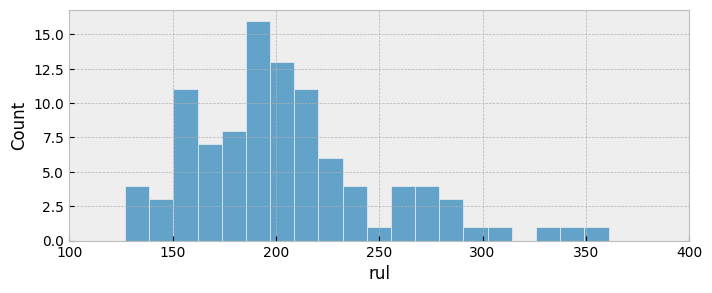

In [30]:
plt.figure(figsize = (8,3))
sns.histplot(failure_time ,bins = 20 )
plt.xlim(100 , 400)

### clip to 125

<Axes: xlabel='rul', ylabel='Count'>

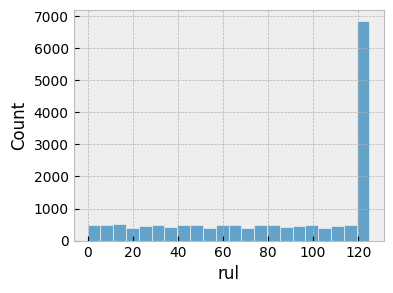

In [31]:
y_train_clipped = y_train.clip(upper = 125)
plt.figure(figsize = (4,3))
sns.histplot(y_train_clipped)

# Random Forest

In [32]:
from sklearn.ensemble import RandomForestRegressor
model_forest = RandomForestRegressor(random_state=42 , n_jobs=-1 )
model_forest.fit(X_train , y_train)

y_pred = model_forest.predict(X_train)
metrics(y_train , y_pred , label = 'train')

y_pred = model_forest.predict(X_test)
metrics(y_test , y_pred , label = 'test')

y_pred = model_forest.predict(X_val)
metrics(y_val , y_pred , 'val')

for train set , RMSE = 15.77 , r2_score = 94.81%
for test set , RMSE = 41.61 , r2_score = 62.10%
for val set , RMSE = 34.12 , r2_score = 32.57%


In [36]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param = {
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
} 

random_search_forest = RandomizedSearchCV(
    estimator=model_forest, 
    param_distributions=param, 
    n_iter=5,       # reduced iterations
    cv=3,           # reduced CV folds
    scoring='r2', 
    random_state=42, 
    n_jobs=-1,
    verbose=1
)
random_search_forest.fit(X_train, y_train_clipped)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: total: 11.4 s
Wall time: 27.4 s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002E6A20EDA00>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002E6A210B470>},
                   random_state=42, scoring='r2', verbose=1)

In [37]:
df_res_forest = pd.DataFrame(random_search_forest.cv_results_).sort_values('mean_test_score')
df_res_forest[['mean_test_score' , 'params']]

,mean_test_score,params
2,0.805901,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
1,0.807241,"{'max_depth': 20, 'min_samples_leaf': 3, 'min_..."
4,0.807241,"{'max_depth': 20, 'min_samples_leaf': 3, 'min_..."
0,0.807844,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
3,0.809356,"{'max_depth': 10, 'min_samples_leaf': 3, 'min_..."


In [41]:
model_fine_forest = random_search_forest.best_estimator_
print(model_fine_forest)

# Evaluate on training set
y_train_pred = model_fine_forest.predict(X_train)
metrics(y_train_clipped, y_train_pred, label='train')

# Evaluate on test set
y_test_pred = model_fine_forest.predict(X_test)
metrics(y_test, y_test_pred, label='test')

# Evaluate on validation set
y_val_pred = model_fine_forest.predict(X_val)
metrics(y_val['RUL'], y_val_pred, label='val')


RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=8,
                      n_jobs=-1, random_state=42)
for train set , RMSE = 15.36 , r2_score = 86.50%
for test set , RMSE = 50.17 , r2_score = 44.90%
for val set , RMSE = 17.85 , r2_score = 81.55%


In [ ]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, GroupKFold

# If you have a grouping variable (e.g. engine_id), set groups = engine_ids_train
USE_GROUP_SPLIT = False

def objective_rf(trial):
    # 1) Hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 10, 50, step=5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7])
    }

    model = RandomForestRegressor(**param, random_state=42, n_jobs=-1)

    # 2) Cross‑validation scheme
    if USE_GROUP_SPLIT:
        cv = GroupKFold(n_splits=5)
        scores = cross_val_score(
            model, X_train, y_train_clipped,
            groups=engine_ids_train,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
    else:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(
            model, X_train, y_train_clipped,
            cv=cv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )

    # 3) Optuna pruning based on intermediate CV results
    # report the mean RMSE so far, and let Optuna prune if it's hopeless
    mean_rmse = -scores.mean()
    trial.report(mean_rmse, step=0)

    if trial.should_prune():
        raise optuna.TrialPruned()

    return mean_rmse

def optimize_hyperparameters_rf(n_trials=100):
    """Run hyperparameter optimization for Random Forest with Optuna."""
    # Use a MedianPruner to stop bad trials early
    pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=0)
    sampler = optuna.samplers.TPESampler(seed=42)

    study = optuna.create_study(
        direction='minimize',
        sampler=sampler,
        pruner=pruner,
        study_name='rf_regressor_cv'
    )
    study.optimize(objective_rf, n_trials=n_trials, show_progress_bar=True)

    print('Best trial:')
    print(f'  RMSE: {study.best_value:.3f}')
    print('  Params:')
    for key, val in study.best_params.items():
        print(f'    {key}: {val}')

    return study.best_params

# Execute optimization
best_params_rf = optimize_hyperparameters_rf(n_trials=100)

# Re‑train best model on full train set
rf_opt = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
rf_opt.fit(X_train, y_train_clipped)

[I 2025-05-03 22:18:47,483] A new study created in memory with name: rf_regressor_cv


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-03 22:19:01,040] Trial 0 finished with value: 18.160826025668985 and parameters: {'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 0 with value: 18.160826025668985.
[I 2025-05-03 22:19:20,055] Trial 1 finished with value: 18.1876756923071 and parameters: {'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 0 with value: 18.160826025668985.
[I 2025-05-03 22:19:32,625] Trial 2 finished with value: 18.191474277076225 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.5}. Best is trial 0 with value: 18.160826025668985.
[I 2025-05-03 22:19:45,193] Trial 3 finished with value: 18.15814501730153 and parameters: {'n_estimators': 600, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 3 with value: 18.15814501730153.
[I 2025-0

In [ ]:
# Final evaluation
def eval_model(model, X, y, label):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2    = model.score(X, y) * 100
    print(f"{label:5s} — RMSE: {rmse:.2f}, R²: {r2:.1f}%")

eval_model(rf_opt, X_train,      y_train_clipped, 'Train')
eval_model(rf_opt, X_test,       y_test,           'Test')
eval_model(rf_opt, X_val,        y_val['RUL'],     'Val')

for train set , RMSE = 48.87 , r2_score = 50.11%
for test set , RMSE = 50.09 , r2_score = 45.09%
for val set , RMSE = 17.86 , r2_score = 81.53%


### best model is random foreset with 82 % accuracy for clipping to 125

### no clipping approach 
#### svm with c = 20 ,r2_score 56% in valiadtion set
### clipping to 125
#### random forest with r2_score 82 % on validation set